In [64]:
import json

import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from tqdm import tqdm

import dataholders as dh
import utils
import points_processing as pp

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, Conv1D, Flatten, MaxPool1D, Dropout
from keras.metrics import binary_accuracy, binary_crossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import class_weight

from livelossplot import PlotLossesKeras

In [2]:
df = pp.prepare_points()

In [3]:
time, low_labels, up_labels, lowT, upT = pp.prepare_data()

In [4]:
pos_time_data, pos_temp_data = pp.generate_positive(low_labels, time, lowT)
print(pos_temp_data.shape)

100%|███████████████████████████████████████████████████████████████████████| 791859/791859 [00:12<00:00, 61061.46it/s]


(2933, 20)


In [5]:
start=80000
end=750000
neg_time_data, neg_temp_data = pp.generate_negative(low_labels[start:end], time[start:end], lowT[start:end])

print(neg_temp_data.shape)

100%|██████████████████████████████████████████████████████████████████████| 670000/670000 [00:02<00:00, 270750.25it/s]


(12971, 20)


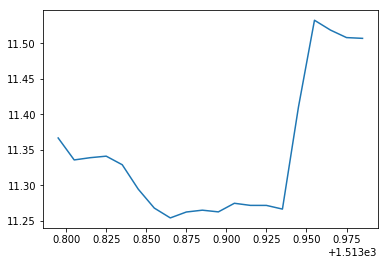

In [6]:
idx = 485

plt.plot(pos_time_data[idx]/1000., pos_temp_data[idx])
plt.show()

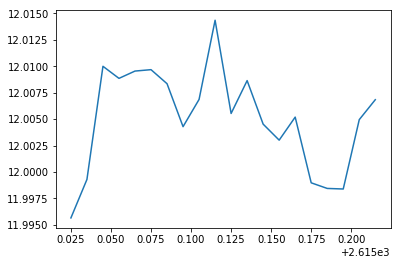

In [7]:
idx = 3402

plt.plot(neg_time_data[idx]/1000., neg_temp_data[idx])
plt.show()

In [8]:
pos_labels = np.ones(pos_temp_data.shape[0])
neg_labels = np.zeros(neg_temp_data.shape[0])

In [9]:
print(pos_labels.shape)
print(neg_labels.shape)

(2933,)
(12971,)


In [17]:
X_data = np.concatenate((pos_temp_data, neg_temp_data))
Y_data = np.concatenate((pos_labels, neg_labels))

In [37]:
# mu = X_data.mean(1, keepdims=True)
# sigma = X_data.std(1, keepdims=True)
# X_data_norm = (X_data - mu) / sigma

X_data_norm = X_data - X_data[:,0:1]

In [41]:
X_data.shape

(15904, 20)

In [42]:
X_data_norm = np.expand_dims(X_data_norm, 2)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data_norm, Y_data, test_size=.1, random_state=0)

print(X_train.shape)
print(X_test.shape)

(14313, 20, 1)
(1591, 20, 1)


In [90]:
inputs = Input(shape=(20,1))
X = Conv1D(20, 3, activation='relu')(inputs)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(40, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(40, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(50, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(50, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Flatten()(X)
X = Dense(1,  activation='sigmoid')(X)

model = Model(inputs=[inputs], outputs=[X])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 20, 1)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 18, 20)            80        
_________________________________________________________________
dropout_42 (Dropout)         (None, 18, 20)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16, 40)            2440      
_________________________________________________________________
dropout_43 (Dropout)         (None, 16, 40)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 14, 40)            4840      
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 40)            0         
__________

In [102]:
inputs = Input(shape=(20,1))
X = LSTM(20, return_sequences=True)(inputs)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = LSTM(50, return_sequences=True)(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Flatten()(X)

X = Dense(1,  activation='sigmoid')(X)

model = Model(inputs=[inputs], outputs=[X])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 20, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 20)            1760      
_________________________________________________________________
dropout_49 (Dropout)         (None, 20, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 50)            14200     
_________________________________________________________________
dropout_50 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1001      
Total para

In [103]:
model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])

In [104]:
weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

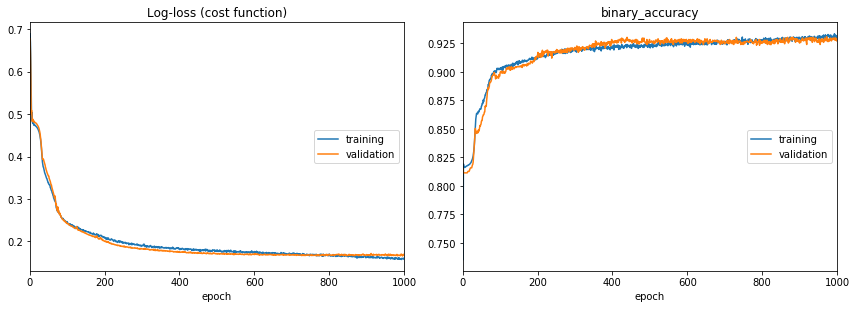

In [105]:
model.fit(X_train, Y_train, 
          epochs=1000, 
          batch_size=4000, 
          class_weight=weight, 
          validation_data=(X_test, Y_test), 
          verbose=0,
          callbacks=[PlotLossesKeras()])

- Rethink sync (!)

- Add more features (wind, other thermometers etc.)

- Conv models

In [101]:
print(model.evaluate(X_train, Y_train, batch_size=4000))
print(model.evaluate(X_test, Y_test, batch_size=4000))

14313/14313 [==============================] - 0s 10us/step
[0.16118175569552926, 0.92943478415182768]
1591/1591 [==============================] - 0s 14us/step
[0.16682811081409454, 0.92834693193435669]


# Notes:

- End to end probably won't work - I mean, it surely can't

## Plan:

- Add normalization